In [ ]:
# Load TOBS data from combined file 1950-1955 using SQL
import dask.dataframe as dd
import pandas as pd
import numpy as np

# SQL: SELECT * FROM weather_1950_2025_combined WHERE ELEMENT = 'TOBS' AND year BETWEEN 1950 AND 1955
tobs_combined = dd.read_parquet('../../../weather_data/weather_1950_2025_combined.parquet').query("ELEMENT == 'TOBS' and year >= 2020 and year <= 2025")

# Compute and cache the results to avoid repeated computations
print("Computing and caching TOBS data...")
tobs_computed = tobs_combined.compute()  # this is where the lazy evaluation stops and the dataframe is computed.
print(f"TOBS 1950-1955: {len(tobs_computed)} station-year combinations")
print(f"Years: {sorted(tobs_computed['year'].unique())}")
print(f"Stations: {tobs_computed['ID'].nunique()}")
print(tobs_computed.head())


Computing and caching TOBS data...
TOBS 1950-1955: 24809 station-year combinations
Years: [2020, 2021, 2023, 2024, 2025]
Stations: 5589
                ID  year ELEMENT  day_1  day_2  day_3  day_4  day_5  day_6  \
14035  CQC00914080  2020    TOBS  256.0  256.0  256.0  267.0  261.0  261.0   
14039  CQC00914801  2020    TOBS  250.0  261.0  250.0  250.0  256.0  256.0   
14967  FMC00914325  2020    TOBS  289.0  289.0  300.0  306.0  294.0  283.0   
14971  FMC00914395  2020    TOBS  294.0  300.0  300.0  300.0  294.0  306.0   
14978  FMC00914590  2020    TOBS  250.0  294.0  306.0  289.0  306.0  261.0   

       day_7  ...  day_356  day_357  day_358  day_359  day_360  day_361  \
14035  267.0  ...    256.0    256.0    261.0    261.0    256.0    256.0   
14039  256.0  ...    267.0    272.0    244.0    267.0    261.0    261.0   
14967  294.0  ...    289.0    289.0    283.0    283.0    289.0    267.0   
14971  294.0  ...    306.0    306.0    306.0    300.0    289.0    294.0   
14978  278.0  ...   

In [ ]:
# SQL: Analyze NaN distribution by year (using cached data)
day_cols = [f'day_{i}' for i in range(1, 366)]

# SQL: SELECT year, COUNT(*) as total_days, COUNT(day_X) as non_null_days
# GROUP BY year
print("NaN Distribution Analysis 1950-1955:")
print("=" * 50)

# Calculate NaN percentage for each year using cached data
nan_stats = []
for year in sorted(tobs_computed['year'].unique()):
    year_data = tobs_computed[tobs_computed['year'] == year][day_cols]
    total_values = len(year_data) * 365
    non_null_values = year_data.count().sum()
    nan_percentage = ((total_values - non_null_values) / total_values) * 100
    nan_stats.append((year, nan_percentage))
    print(f"Year {year}: {nan_percentage:.1f}% NaN values")

# Summary statistics
nan_percentages = [stat[1] for stat in nan_stats]
print(f"\nSummary:")
print(f"Average NaN: {np.mean(nan_percentages):.1f}%")
print(f"Min NaN: {np.min(nan_percentages):.1f}% (Year {nan_stats[np.argmin(nan_percentages)][0]})")
print(f"Max NaN: {np.max(nan_percentages):.1f}% (Year {nan_stats[np.argmax(nan_percentages)][0]})")


NaN Distribution Analysis 1950-1955:
Year 2020: 11.5% NaN values
Year 2021: 11.2% NaN values
Year 2023: 11.1% NaN values
Year 2024: 11.1% NaN values
Year 2025: 34.5% NaN values

Summary:
Average NaN: 15.9%
Min NaN: 11.1% (Year 2023)
Max NaN: 34.5% (Year 2025)


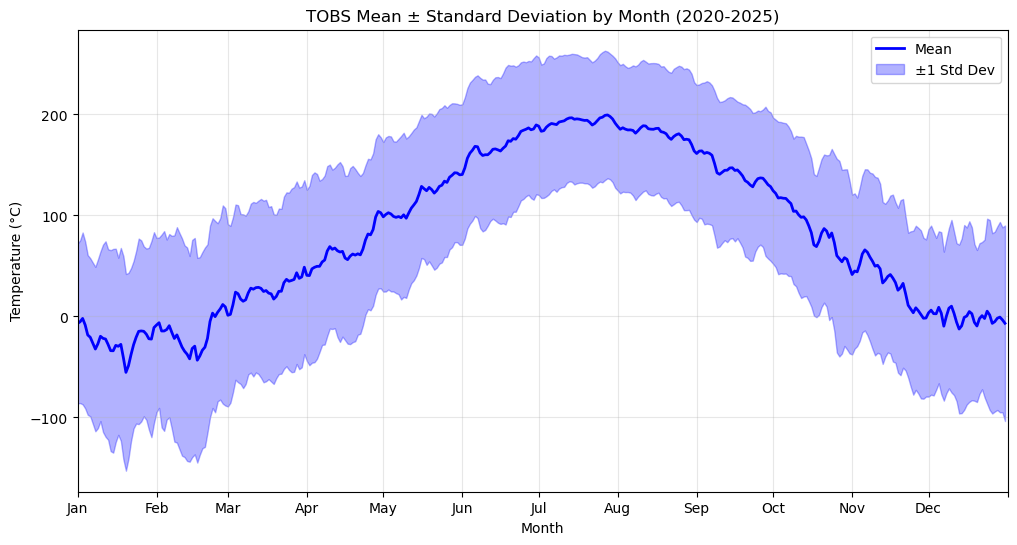

In [ ]:
# Use Dask operations for efficient computation
day_cols = [f'day_{i}' for i in range(1, 366)]
daily_means = tobs_computed[day_cols].mean()
daily_stds = tobs_computed[day_cols].std()

# Create plot with month labels on x-axis
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
days = range(1, 366)
plt.plot(days, daily_means, 'b-', linewidth=2, label='Mean')
plt.fill_between(days, 
                 daily_means - daily_stds,
                 daily_means + daily_stds, 
                 alpha=0.3, color='blue', label='±1 Std Dev')

# Set up x-axis with month labels
month_boundaries = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 366]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']

plt.xlim(1, 365)
plt.xticks(month_boundaries, month_labels)
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('TOBS Mean ± Standard Deviation by Month (2020-2025)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Join TOBS data with station information
import dask.dataframe as dd
import os

print("Loading station information...")
stations_path = '../weather_info/stations_dask.parquet'
print(f"Looking for stations file at: {stations_path}")
print(f"File exists: {os.path.exists(stations_path)}")

try:
    stations_df = dd.read_parquet(stations_path)
    print(f"✓ Loaded {len(stations_df)} stations")
    
    # Convert to pandas for easier joining
    print("Converting stations to pandas for joining...")
    stations_pandas = stations_df.compute()
    print(f"✓ Converted to pandas: {stations_pandas.shape}")
    
    # Show station data info
    print(f"Station columns: {list(stations_pandas.columns)}")
    print(f"Sample station IDs: {stations_pandas['station_id'].head().tolist()}")
    
    # Join TOBS data with station information
    print("Joining TOBS data with station information...")
    print(f"TOBS data shape: {tobs_computed.shape}")
    print(f"TOBS sample IDs: {tobs_computed['ID'].head().tolist()}")
    
    tobs_with_stations = tobs_computed.merge(
        stations_pandas, 
        left_on='ID', 
        right_on='station_id', 
        how='left'
    )
    
    print(f"✓ Joined data shape: {tobs_with_stations.shape}")
    print(f"Columns: {list(tobs_with_stations.columns)}")
    
    # Show sample of joined data
    print("\nSample of joined data:")
    print(tobs_with_stations[['ID', 'year', 'latitude', 'longitude', 'elevation', 'name', 'state']].head())
    
    # Check for missing station information
    missing_stations = tobs_with_stations['latitude'].isna().sum()
    print(f"\nStations with missing location data: {missing_stations} out of {len(tobs_with_stations)}")
    print(f"Coverage: {((len(tobs_with_stations) - missing_stations) / len(tobs_with_stations) * 100):.1f}%")
    
except Exception as e:
    print(f"Error: {e}")
    print("Please check the file path and try again.")


Loading station information...
Looking for stations file at: ../weather_info/stations_dask.parquet
File exists: True
✓ Loaded 129658 stations
Converting stations to pandas for joining...
✓ Converted to pandas: (129658, 10)
Station columns: ['station_id', 'latitude', 'longitude', 'elevation', 'state', 'name', 'gsn_flag', 'hcn_crn_flag', 'wmo_id', 'country_code']
Sample station IDs: ['ACW00011604', 'ACW00011647', 'AE000041196', 'AEM00041194', 'AEM00041217']
Joining TOBS data with station information...
TOBS data shape: (24809, 368)
TOBS sample IDs: ['CQC00914080', 'CQC00914801', 'FMC00914325', 'FMC00914395', 'FMC00914590']
✓ Joined data shape: (24809, 378)
Columns: ['ID', 'year', 'ELEMENT', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31', '

Creating hemisphere-specific plots...
Northern Hemisphere: 24809 station-year combinations
Southern Hemisphere: 0 station-year combinations
Calculating daily statistics for Northern Hemisphere...
Calculating daily statistics for Southern Hemisphere...


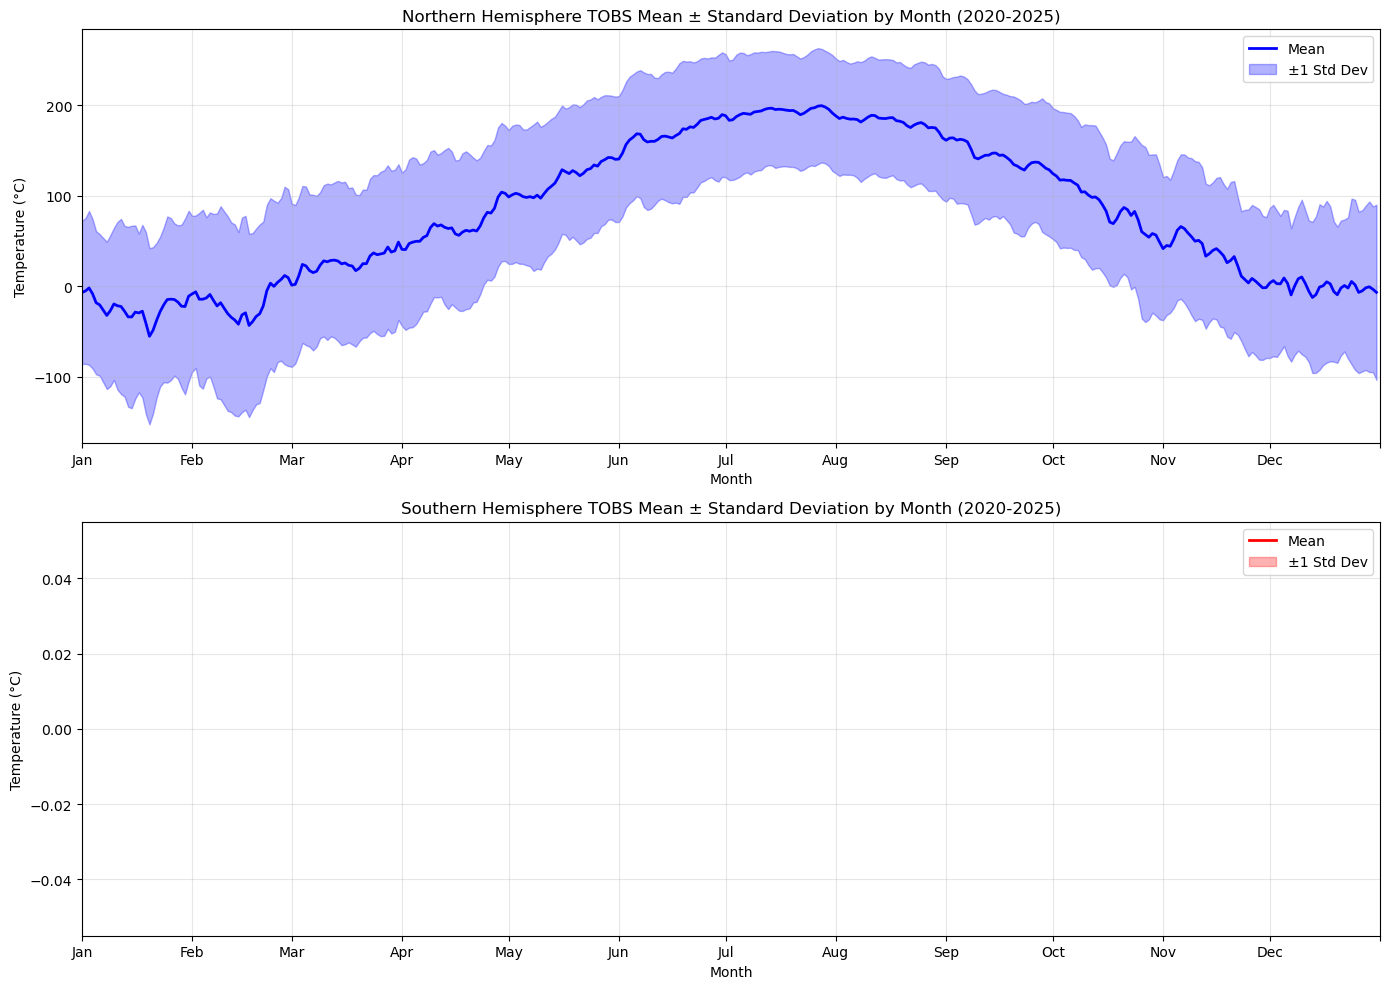


Summary Statistics:
Northern Hemisphere - Mean temp range: -55.3°C to 199.5°C
Southern Hemisphere - Mean temp range: nan°C to nan°C
Northern Hemisphere - Avg std dev: 78.5°C
Southern Hemisphere - Avg std dev: nan°C


In [ ]:
# Plot mean ± std for Northern and Southern Hemispheres separately
import matplotlib.pyplot as plt
import numpy as np

print("Creating hemisphere-specific plots...")

# Separate data by hemisphere
northern_hemisphere = tobs_with_stations[tobs_with_stations['latitude'] >= 0]
southern_hemisphere = tobs_with_stations[tobs_with_stations['latitude'] < 0]

print(f"Northern Hemisphere: {len(northern_hemisphere)} station-year combinations")
print(f"Southern Hemisphere: {len(southern_hemisphere)} station-year combinations")

# Get day columns
day_cols = [f'day_{i}' for i in range(1, 366)]

# Calculate daily means and stds for each hemisphere
print("Calculating daily statistics for Northern Hemisphere...")
northern_daily_means = northern_hemisphere[day_cols].mean()
northern_daily_stds = northern_hemisphere[day_cols].std()

print("Calculating daily statistics for Southern Hemisphere...")
southern_daily_means = southern_hemisphere[day_cols].mean()
southern_daily_stds = southern_hemisphere[day_cols].std()

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Northern Hemisphere plot
days = range(1, 366)
ax1.plot(days, northern_daily_means, 'b-', linewidth=2, label='Mean')
ax1.fill_between(days, 
                 northern_daily_means - northern_daily_stds,
                 northern_daily_means + northern_daily_stds, 
                 alpha=0.3, color='blue', label='±1 Std Dev')

# Set up x-axis with month labels
month_boundaries = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 366]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']

ax1.set_xlim(1, 365)
ax1.set_xticks(month_boundaries)
ax1.set_xticklabels(month_labels)
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Northern Hemisphere TOBS Mean ± Standard Deviation by Month (2020-2025)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Southern Hemisphere plot
ax2.plot(days, southern_daily_means, 'r-', linewidth=2, label='Mean')
ax2.fill_between(days, 
                 southern_daily_means - southern_daily_stds,
                 southern_daily_means + southern_daily_stds, 
                 alpha=0.3, color='red', label='±1 Std Dev')

ax2.set_xlim(1, 365)
ax2.set_xticks(month_boundaries)
ax2.set_xticklabels(month_labels)
ax2.set_xlabel('Month')
ax2.set_ylabel('Temperature (°C)')
ax2.set_title('Southern Hemisphere TOBS Mean ± Standard Deviation by Month (2020-2025)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Northern Hemisphere - Mean temp range: {northern_daily_means.min():.1f}°C to {northern_daily_means.max():.1f}°C")
print(f"Southern Hemisphere - Mean temp range: {southern_daily_means.min():.1f}°C to {southern_daily_means.max():.1f}°C")
print(f"Northern Hemisphere - Avg std dev: {northern_daily_stds.mean():.1f}°C")
print(f"Southern Hemisphere - Avg std dev: {southern_daily_stds.mean():.1f}°C")


In [ ]:
# Investigate Southern Hemisphere TOBS data availability
print("INVESTIGATING SOUTHERN HEMISPHERE TOBS DATA")
print("=" * 60)

# Check latitude distribution in the joined data
print("Latitude distribution in TOBS data:")
print(f"Min latitude: {tobs_with_stations['latitude'].min():.2f}")
print(f"Max latitude: {tobs_with_stations['latitude'].max():.2f}")
print(f"Mean latitude: {tobs_with_stations['latitude'].mean():.2f}")

# Count stations by hemisphere
northern_count = (tobs_with_stations['latitude'] >= 0).sum()
southern_count = (tobs_with_stations['latitude'] < 0).sum()
total_count = len(tobs_with_stations)

print(f"\nStation distribution:")
print(f"Northern Hemisphere (lat >= 0): {northern_count:,} ({northern_count/total_count*100:.1f}%)")
print(f"Southern Hemisphere (lat < 0): {southern_count:,} ({southern_count/total_count*100:.1f}%)")

# Check if there are any southern hemisphere stations
if southern_count > 0:
    print(f"\n✓ Found {southern_count:,} Southern Hemisphere station-year combinations")
    
    # Show some southern hemisphere stations
    southern_stations = tobs_with_stations[tobs_with_stations['latitude'] < 0]
    print(f"\nSample Southern Hemisphere stations:")
    print(southern_stations[['ID', 'latitude', 'longitude', 'name', 'state']].head(10))
    
    # Check latitude range for southern stations
    print(f"\nSouthern Hemisphere latitude range:")
    print(f"Min: {southern_stations['latitude'].min():.2f}")
    print(f"Max: {southern_stations['latitude'].max():.2f}")
    
else:
    print(f"\n✗ No Southern Hemisphere stations found in TOBS data")
    print("This could be due to:")
    print("1. Limited Southern Hemisphere station coverage in the dataset")
    print("2. Different data collection periods")
    print("3. Different station selection criteria")

# Check the original station data to see if southern stations exist
print(f"\n" + "="*60)
print("CHECKING ORIGINAL STATION DATA")
print("="*60)

# Load the full station data to check global coverage
try:
    full_stations = stations_pandas  # Use the already loaded stations data
    print(f"Total stations in database: {len(full_stations):,}")
    
    # Check latitude distribution in full station data
    print(f"\nFull station latitude distribution:")
    print(f"Min latitude: {full_stations['latitude'].min():.2f}")
    print(f"Max latitude: {full_stations['latitude'].max():.2f}")
    
    # Count stations by hemisphere in full data
    full_northern = (full_stations['latitude'] >= 0).sum()
    full_southern = (full_stations['latitude'] < 0).sum()
    full_total = len(full_stations)
    
    print(f"\nFull station distribution:")
    print(f"Northern Hemisphere: {full_northern:,} ({full_northern/full_total*100:.1f}%)")
    print(f"Southern Hemisphere: {full_southern:,} ({full_southern/full_total*100:.1f}%)")
    
    if full_southern > 0:
        print(f"\n✓ Found {full_southern:,} Southern Hemisphere stations in the full database")
        southern_full = full_stations[full_stations['latitude'] < 0]
        print(f"Sample Southern Hemisphere stations from full database:")
        print(southern_full[['station_id', 'latitude', 'longitude', 'name', 'state']].head(10))
        
        # Check if any of these southern stations have TOBS data
        southern_station_ids = set(southern_full['station_id'])
        tobs_station_ids = set(tobs_with_stations['ID'])
        overlap = southern_station_ids.intersection(tobs_station_ids)
        
        print(f"\nSouthern stations with TOBS data: {len(overlap)} out of {len(southern_station_ids)}")
        if len(overlap) > 0:
            print("Sample overlapping stations:")
            for station_id in list(overlap)[:5]:
                station_info = southern_full[southern_full['station_id'] == station_id].iloc[0]
                print(f"  {station_id}: {station_info['name']} (lat: {station_info['latitude']:.2f})")
        else:
            print("✗ No Southern Hemisphere stations have TOBS data in this dataset")
    
except Exception as e:
    print(f"Error checking full station data: {e}")


INVESTIGATING SOUTHERN HEMISPHERE TOBS DATA
Latitude distribution in TOBS data:
Min latitude: 1.08
Max latitude: 71.32
Mean latitude: 40.21

Station distribution:
Northern Hemisphere (lat >= 0): 24,809 (100.0%)
Southern Hemisphere (lat < 0): 0 (0.0%)

✗ No Southern Hemisphere stations found in TOBS data
This could be due to:
1. Limited Southern Hemisphere station coverage in the dataset
2. Different data collection periods
3. Different station selection criteria

CHECKING ORIGINAL STATION DATA
Total stations in database: 129,658

Full station latitude distribution:
Min latitude: -90.00
Max latitude: 83.65

Full station distribution:
Northern Hemisphere: 104,301 (80.4%)
Southern Hemisphere: 25,357 (19.6%)

✓ Found 25,357 Southern Hemisphere stations in the full database
Sample Southern Hemisphere stations from full database:
      station_id  latitude  longitude                 name state
219  AO000066160   -8.8500    13.2330               LUANDA  None
220  AO000066270  -11.4170    15.1

In [ ]:
# Investigate if Southern Hemisphere stations have other measurements (not just TOBS)
print("INVESTIGATING SOUTHERN HEMISPHERE MEASUREMENT AVAILABILITY")
print("=" * 70)

# First, let's check what elements are available in our TOBS dataset
print("Elements in our current TOBS dataset:")
print(f"Unique elements: {tobs_with_stations['ELEMENT'].unique()}")

# Now let's check the original weather data to see what elements are available globally
print(f"\n" + "="*70)
print("CHECKING GLOBAL WEATHER DATA FOR ALL ELEMENTS")
print("="*70)

try:
    # Load the original combined weather data to see all elements
    print("Loading original weather data to check all elements...")
    weather_combined = dd.read_parquet('../../../weather_data/weather_1950_2025_combined.parquet')
    
    # Filter for our time period (2020-2025)
    weather_filtered = weather_combined.query("year >= 2020 and year <= 2025")
    
    # Get all unique elements in the dataset
    all_elements = weather_filtered['ELEMENT'].unique().compute()
    print(f"All elements available in 2020-2025: {sorted(all_elements)}")
    
    # Count records by element
    print(f"\nRecord counts by element:")
    element_counts = weather_filtered['ELEMENT'].value_counts().compute()
    for element, count in element_counts.head(10).items():
        print(f"  {element}: {count:,} records")
    
    # Now let's check if Southern Hemisphere stations have any measurements at all
    print(f"\n" + "="*70)
    print("CHECKING SOUTHERN HEMISPHERE STATIONS FOR ANY MEASUREMENTS")
    print("="*70)
    
    # Get all unique station IDs from the weather data
    all_station_ids = weather_filtered['ID'].unique().compute()
    print(f"Total unique stations in weather data: {len(all_station_ids):,}")
    
    # Join with station information to get latitudes
    print("Joining weather data with station information...")
    weather_with_stations = weather_filtered.merge(
        stations_pandas, 
        left_on='ID', 
        right_on='station_id', 
        how='left'
    )
    
    # Compute the joined data
    print("Computing joined data...")
    weather_computed = weather_with_stations.compute()
    
    # Check latitude distribution in all weather data
    print(f"\nLatitude distribution in ALL weather data:")
    print(f"Min latitude: {weather_computed['latitude'].min():.2f}")
    print(f"Max latitude: {weather_computed['latitude'].max():.2f}")
    
    # Count stations by hemisphere for ALL elements
    all_northern = (weather_computed['latitude'] >= 0).sum()
    all_southern = (weather_computed['latitude'] < 0).sum()
    all_total = len(weather_computed)
    
    print(f"\nAll weather data distribution:")
    print(f"Northern Hemisphere: {all_northern:,} ({all_northern/all_total*100:.1f}%)")
    print(f"Southern Hemisphere: {all_southern:,} ({all_southern/all_total*100:.1f}%)")
    
    if all_southern > 0:
        print(f"\n✓ Found {all_southern:,} Southern Hemisphere records in ALL weather data")
        
        # Show what elements are available for Southern Hemisphere
        southern_data = weather_computed[weather_computed['latitude'] < 0]
        southern_elements = southern_data['ELEMENT'].value_counts()
        
        print(f"\nSouthern Hemisphere elements available:")
        for element, count in southern_elements.head(10).items():
            print(f"  {element}: {count:,} records")
        
        # Check if TOBS is among them
        if 'TOBS' in southern_elements.index:
            print(f"\n✓ TOBS data IS available for Southern Hemisphere: {southern_elements['TOBS']:,} records")
        else:
            print(f"\n✗ TOBS data is NOT available for Southern Hemisphere")
            print("Available elements for Southern Hemisphere:")
            print(southern_elements.index.tolist())
        
        # Show sample Southern Hemisphere stations with their data
        print(f"\nSample Southern Hemisphere stations with measurements:")
        southern_stations = southern_data[['ID', 'latitude', 'longitude', 'name', 'ELEMENT']].drop_duplicates()
        print(southern_stations.head(10))
        
    else:
        print(f"\n✗ No Southern Hemisphere records found in ANY weather data")
        print("This suggests a fundamental lack of Southern Hemisphere station coverage")
    
    # Compare TOBS vs other elements for Southern Hemisphere
    if all_southern > 0:
        print(f"\n" + "="*70)
        print("COMPARING TOBS vs OTHER ELEMENTS FOR SOUTHERN HEMISPHERE")
        print("="*70)
        
        # Check if TOBS exists at all in the dataset
        tobs_exists = 'TOBS' in weather_computed['ELEMENT'].values
        print(f"TOBS element exists in dataset: {tobs_exists}")
        
        if tobs_exists:
            # Check TOBS specifically for Southern Hemisphere
            tobs_data = weather_computed[weather_computed['ELEMENT'] == 'TOBS']
            tobs_southern = tobs_data[tobs_data['latitude'] < 0]
            print(f"TOBS records for Southern Hemisphere: {len(tobs_southern):,}")
            
            if len(tobs_southern) > 0:
                print("✓ TOBS data IS available for Southern Hemisphere!")
                print("Sample Southern Hemisphere TOBS stations:")
                print(tobs_southern[['ID', 'latitude', 'longitude', 'name']].drop_duplicates().head())
            else:
                print("✗ No TOBS data for Southern Hemisphere stations")
                print("This suggests TOBS measurements are not collected for Southern Hemisphere stations")
        
        # Check other common elements
        common_elements = ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'TAVG']
        print(f"\nChecking other common elements for Southern Hemisphere:")
        for element in common_elements:
            if element in weather_computed['ELEMENT'].values:
                element_data = weather_computed[weather_computed['ELEMENT'] == element]
                element_southern = element_data[element_data['latitude'] < 0]
                print(f"  {element}: {len(element_southern):,} Southern Hemisphere records")
            else:
                print(f"  {element}: Not available in dataset")

except Exception as e:
    print(f"Error loading weather data: {e}")
    print("This might be due to the file path or data format issues")


INVESTIGATING SOUTHERN HEMISPHERE MEASUREMENT AVAILABILITY
Elements in our current TOBS dataset:
Unique elements: <StringArray>
['TOBS']
Length: 1, dtype: string

CHECKING GLOBAL WEATHER DATA FOR ALL ELEMENTS
Loading original weather data to check all elements...
All elements available in 2020-2025: ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS']

Record counts by element:
  PRCP: 203,753 records
  SNOW: 130,634 records
  SNWD: 91,427 records
  TMIN: 67,581 records
  TMAX: 67,330 records
  TOBS: 24,809 records

CHECKING SOUTHERN HEMISPHERE STATIONS FOR ANY MEASUREMENTS
Total unique stations in weather data: 53,373
Joining weather data with station information...
Computing joined data...

Latitude distribution in ALL weather data:
Min latitude: -90.00
Max latitude: 82.50

All weather data distribution:
Northern Hemisphere: 551,104 (94.1%)
Southern Hemisphere: 34,430 (5.9%)

✓ Found 34,430 Southern Hemisphere records in ALL weather data

Southern Hemisphere elements available:
  PRCP: 2